In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX (Remove if you want to use GPU)

import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm, trange

# deteministic random numbers
np.random.seed(0)
random.seed(0)

ModuleNotFoundError: No module named 'tqdm'

# Linkage Synthesis Challenge Problem Advanced Code
Here we will tackle the problem with a more complex GA approach. In this notebook, rather than just optimizing the node positions, we will also optimize the connectivity of the mechanims itself. First let's just load the target curves like we did before:


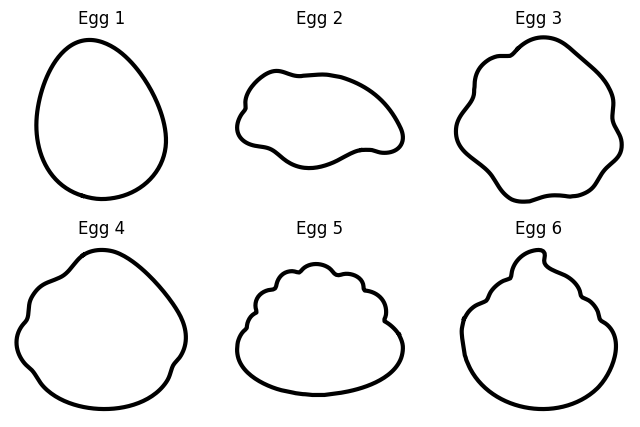

In [ ]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Egg {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


## GA Full Mechanism Generation
To set up the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. This code effectively just flattens the matrices and variables describing our mechanism into a single vector. However, this representation scheme is highly suboptimal, and can be improved significantly. As a demonstration, we will slightly improve upon this representation, though we encourage you to take this further. As we discussed, we can replace the edges with a connectivity matrrix. We also know the connectivity matrix is symmetric (if nodes 1 and 2 are connected nodes 2 and 1 are also connected) and has a diagonal equal to zero. To avoid making the optimization come up with the whole connectivity matrix, we will only have it come up with the upper triangular half of the matrix (not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. We can further simplify the process by selecting a fixed motor position and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism:

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be `[1,0]`. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

Since we know the types of the first two nodes, we save another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we have a (slightly) improved 1D representation scheme, we will set up our problem with this many parameters. We also need to specify our constraints! Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/constraints/index.html)) as less than or equal to zero constraints. We will set the two constraints on distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo.
<ul>
    <li>
        <code>__init__</code>: We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype. As such, we create a dictionary of variables and specify which type of variable each one is.
    </li>
    <li>
<code>convert_1D_to_mech</code>: Reformats our dictionary of variables into design info that our simulator uses (edges, x0, etc.). You will need to update this function if you change the way you parameterize mechanisms. IMPORTANT: This function should not be confused for the. We have also provided a function, <code> convert_mech_to_1D </code> to do the opposite, which you may find useful. It is currently unused and is commented out.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct the mechanism using <code>convert_1D_to_mech</code>. Next, perform the same evaluations as we did in the starter notebook.
    </li>
</ul>

In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling, Sampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

from LINKS.Optimization import DifferentiableTools, Tools

In [ ]:
PROBLEM_TOOLS = Tools( # we have to define this outside the class due to pymoo deepcopy limitations
            device='cpu' # device to run the optimization on
        )  
PROBLEM_TOOLS.compile() # compile the functions for faster runs

class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_curve, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                variables["C" + str(j) + "_" + str(i)] = Binary()

        # We Delete C0_1 since we know node 1 is connected to the motor
        del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.target_curve = target_curve


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target joints index
        target_idx = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C = np.zeros((N,N))
        x["C0_1"] = 1

        for i in range(N):
            for j in range(i):
                # C[i,j] = x["C" + str(j) + "_" + str(i)]
                C[j,i] = x["C" + str(j) + "_" + str(i)]

        edges = np.array(np.where(C==1)).T
        
        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_joints = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,1])

        return x0, edges, fixed_joints, motor, target_idx

    def convert_mech_to_1D(self, x0, edges, fixed_joints, target_idx=None, **kwargs):
        # This function assumes motor to be [0, 1] our random mechanism generator automatically does this
        N = self.N

        # Initialize dictionary to store 1D representation of mechanism
        x = {}

        # Store target node value
        if target_idx is None:
            target_idx = x0.shape[0]-1 # Assume last node is the target if not specified
            
        x["target"] = target_idx

        # Store connectivity matrix in its flattened form
        C = np.zeros((N,N), dtype=bool)
        C[edges[:,0], edges[:,1]] = 1
        C[edges[:,1], edges[:,0]] = 1
       
        for i in range(N):
            for j in range(i):
                x["C" + str(j) + "_" + str(i)] = C[i,j]

        del x["C0_1"]
        
        # Store position matrix in its flattened form
        if x0.shape[0] != N:
            x0 = np.pad(x0, ((0, N - x0.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        for i in range(2*N):
            x["X0" + str(i)] = x0.flatten()[i]

        # Store fixed nodes in boolean vector form
        for i in range(N):
            x["fixed_nodes" + str(i)] = (i in fixed_joints) or (i>=N)

        return x

    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        x0, edges, fixed_joints, motor, target_idx = self.convert_1D_to_mech(x)
        
        # Simulate
        distance, material = PROBLEM_TOOLS(x0,
                                edges,
                                fixed_joints,
                                motor,
                                self.target_curve,
                                target_idx=target_idx
                            )

        out["F"] = np.array([distance, material])
        out["G"] = out["F"] - np.array([0.75, 10.0])  # Constraints: distance <= 0.75, material <= 10.0


Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 6 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

In [ ]:
problem = mechanism_synthesis_optimization(target_curves[1], N=6)

algorithm = NSGA2(pop_size=100,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                #   mutation=PolynomialMutation(prob=0.9),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=0
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |           INF |           INF |             - |             -
     2 |      200 |      1 |  0.7779535055 |           INF |             - |             -
     3 |      300 |      1 |  0.7779535055 |           INF |             - |             -
     4 |      400 |      1 |  0.7779535055 |           INF |             - |             -
     5 |      500 |      1 |  0.7779535055 |           INF |             - |             -
     6 |      600 |      1 |  0.7779535055 |           INF |             - |             -
     7 |      700 |      1 |  0.7779535055 |           INF |             - |             -
     8 |      800 |      1 |  0.7779535055 |           INF |             - |             -
     9 |      900 |      1 |  0.7585495710 |           INF |             - |             -
    10 |     1000 |      1 |  0.7585495710 |           INF |             - |             -

In [ ]:
if results.X is None:
    print("No feasible solution found !!!!!")

No feasible solution found !!!!!


You can see that if you just run GA you will not be able to find any good solutions, even for smaller mechanisms with 6 joints! 

In the starter notebook we gave you a mechanism to initialize GA with. Now we introduce the `MechanismRandomizer` class which can help you generate random mechanisms of any size you need. Let's see how this class works (The first time you run this it will be a little slow):

In [ ]:
from LINKS.Optimization import MechanismRandomizer
from LINKS.Visualization import MechanismVisualizer

In [ ]:
randomizer = MechanismRandomizer(
    min_size = 6, # smalllest mechanism to sample
    max_size = 14, # largest mechanism to sample
    device='cpu')

visualizer = MechanismVisualizer()

In [ ]:
random_mechanism = randomizer()

# Let's see what the output looks like (it is exactly like the submission format)
print(random_mechanism)

{'x0': array([[0.96048002, 0.37513343],
       [0.99879355, 0.24876935],
       [0.49311482, 0.06676837],
       [0.28653182, 0.63725824],
       [0.8377569 , 0.14618064],
       [0.20960542, 0.46454909]]), 'edges': array([[0, 1],
       [1, 3],
       [2, 3],
       [3, 5],
       [4, 5]]), 'fixed_joints': array([0, 2, 4]), 'motor': array([0, 1])}


<Axes: >

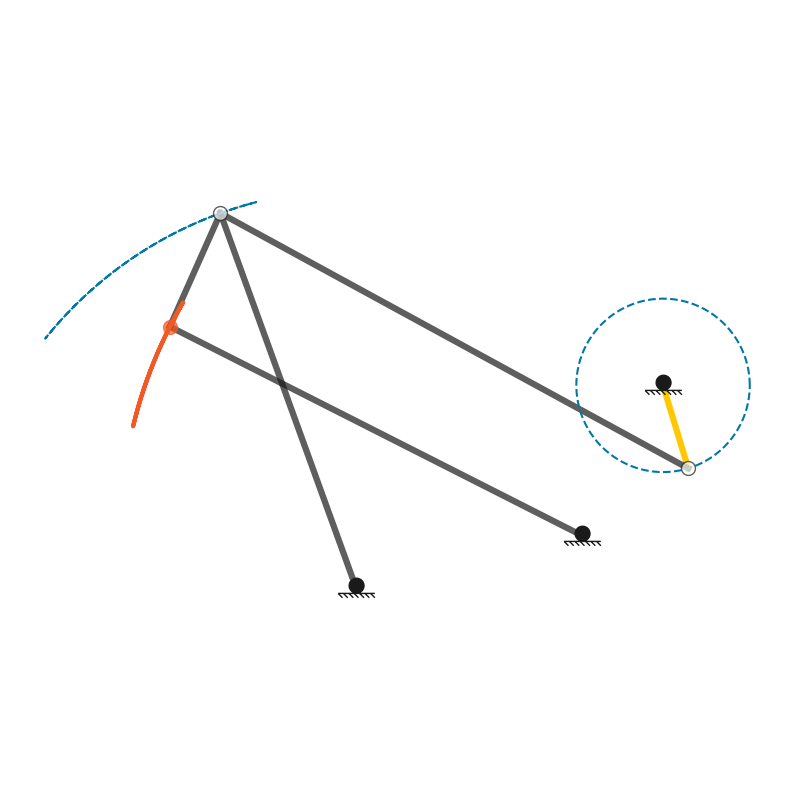

In [ ]:
# Visualize the random mechanism
visualizer(**random_mechanism)

In [ ]:
# Now let's generate 100 mechanisms of size 7 and initilize a population for optimization
mechanisms = [randomizer(n=7) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
problem = mechanism_synthesis_optimization(target_curves[1], N=7)

initial_population = [problem.convert_mech_to_1D(**mech) for mech in mechanisms]

class sample_from_random(Sampling):
        def _do(self, problem, n_samples, **kwargs):
                return np.array([initial_population[i%len(initial_population)] for i in range(n_samples)])

F = problem.evaluate(np.array(initial_population))[0]
print(f'Best Distance Performance In random population: {F[:,0].min()}')
print(f'Best Material Performance In random population: {F[:,1].min()}')

Best Distance Performance In random population: 1.4918473958969116
Best Material Performance In random population: 3.9050841331481934


In [ ]:
algorithm = NSGA2(pop_size=100,
                  sampling=sample_from_random(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PolynomialMutation(prob=0.5),
                  eliminate_duplicates=MixedVariableDuplicateElimination())

results = minimize(problem,
                algorithm,
                ('n_gen', 100),
                verbose=True,
                save_history=True,
                seed=123
                )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.8068205118 |  9.0035807598 |             - |             -
     2 |      200 |      1 |  0.8068205118 |  7.9413599074 |             - |             -
     3 |      300 |      1 |  0.3041574955 |  6.7534441745 |             - |             -
     4 |      400 |      1 |  0.3041574955 |  5.9106362784 |             - |             -
     5 |      500 |      1 |  0.3041574955 |  5.6705343354 |             - |             -
     6 |      600 |      1 |  0.3041574955 |  5.2590543783 |             - |             -
     7 |      700 |      1 |  0.1190508008 |  4.3487125355 |             - |             -
     8 |      800 |      1 |  0.1190508008 |  4.0359340101 |             - |             -
     9 |      900 |      1 |  0.1190508008 |  3.8640289956 |             - |             -
    10 |     1000 |      1 |  0.1190508008 |  3.6347331434 |             - |             -

We see that if we initialize GA with some valid samples, it is much more likely to succeed! Let's take a look at the solutions of this run:

In [ ]:
from LINKS.Visualization import GAVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Geometry import CurveEngine

Hyper Volume ~ 0.786230


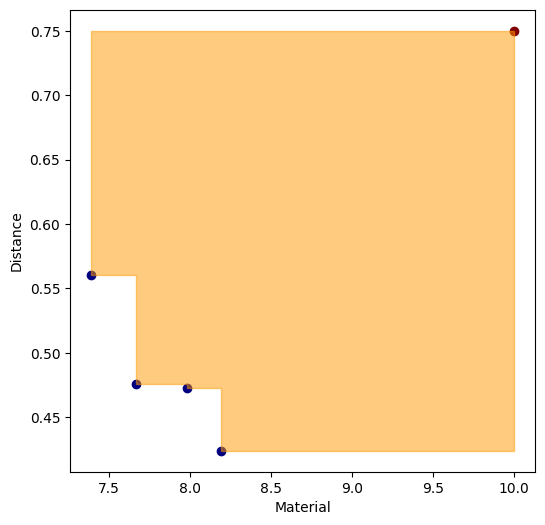

In [ ]:
from pymoo.indicators.hv import HV
ga_visualizer = GAVisualizer()
solver = MechanismSolver(device='cpu')
curve_engine = CurveEngine(device='cpu')

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.75, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    ga_visualizer.plot_HV(results.F, ref_point, objective_labels=['Distance', 'Material']) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

Now Let's visualize the best solution for distance

In [ ]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,0])
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[best_idx])
    else:
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
else:
    print('Did Not Find Solutions!!')

Distance: 0.4240, Material: 8.1902


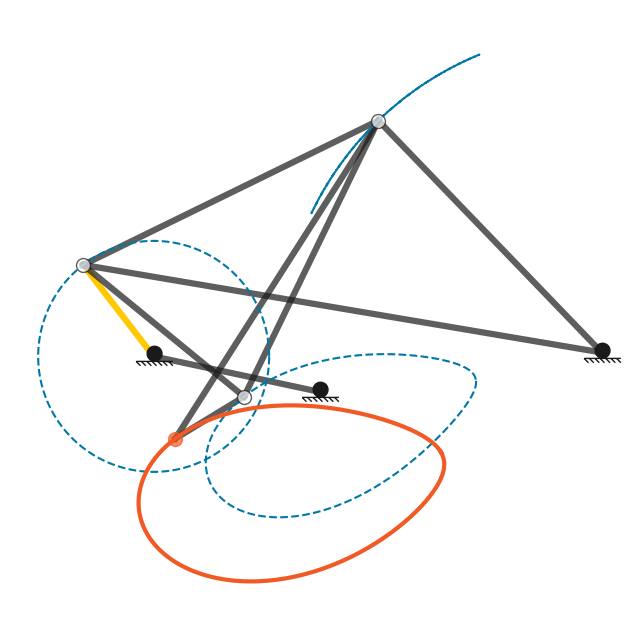

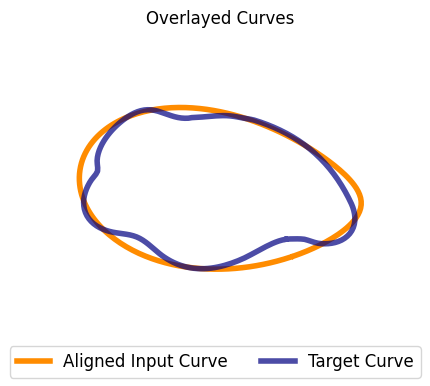

In [ ]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, highlight=target_idx, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[target_idx]
curve_engine.visualize_comparison(
    traced_curve,
    target_curves[1]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

Now Let's visualize the best solution for material

In [ ]:
if not results.X is None:
    if type(results.X)!=dict:
        best_idx = np.argmin(results.F[:,1])
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[best_idx])
    else:
        best_sol, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
else:
    print('Did Not Find Solutions!!')

Distance: 0.5606, Material: 7.3921


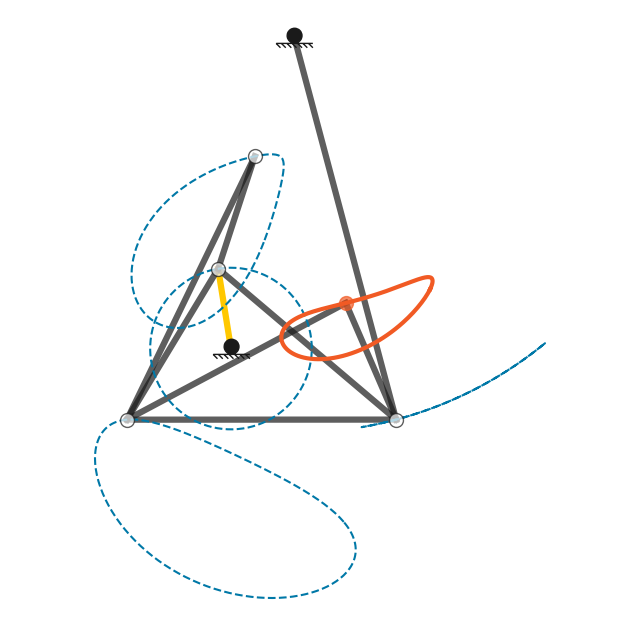

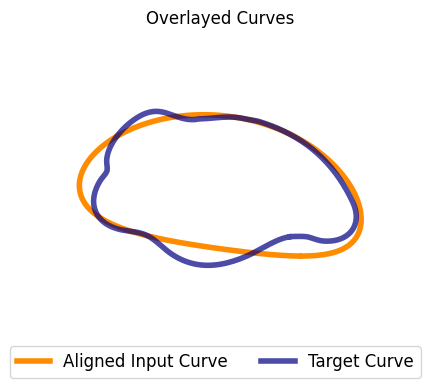

In [ ]:
plt.figure(figsize=(8,8))
visualizer(best_sol, edges, fixed_joints, motor, ax=plt.gca())

traced_curve = solver(best_sol, edges, fixed_joints, motor)[target_idx]
curve_engine.visualize_comparison(
    traced_curve,
    target_curves[1]
)

print(f'Distance: {results.F[best_idx,0]:.4f}, Material: {results.F[best_idx,1]:.4f}')

You can use this population to make a submission:

In [ ]:
from LINKS.CP import make_empty_submission, evaluate_submission

submission = make_empty_submission()

# add out population to submission
if not results.X is None:
    for i in range(results.X.shape[0]):
        if not isinstance(results.X, dict):
            x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X[i])
        else:
            x0_member, edges, fixed_joints, motor, target_idx  = problem.convert_1D_to_mech(results.X)
        
        mech = {
            'x0': x0_member,
            'edges': edges,
            'fixed_joints': fixed_joints,
            'motor': motor,
            'target_joint': target_idx
        }
        
        submission['Problem 2'].append(mech)

In [ ]:
evaluate_submission(submission)

{'Overall Score': 0.13103841360318333,
 'Score Breakdown': {'Problem 1': 0.0,
  'Problem 2': 0.7862304816190999,
  'Problem 3': 0.0,
  'Problem 4': 0.0,
  'Problem 5': 0.0,
  'Problem 6': 0.0}}

You can see that GA is still not doing great with handling different mechanisms. You could adjust the initialization more, change mutation and cross-over functionality. So far however, we have not yet touched on gradient-based optimization. What if we took the solutions of GA and optimized for each of the objectives.

Now let's take the GA solutions from above and just optimize for the lowest distance. Then we will add the optimized solutions to the population we have and see how the hypervolume changes.

 **Note that if the material use exceeds 10 during this optimization the score will not change How could you address this?** 

In [ ]:
from LINKS.Optimization import DifferentiableTools

In [ ]:
differentiable_optimization_tools = DifferentiableTools(
    device='cpu' # device to run the optimization on
)  
differentiable_optimization_tools.compile() # compile the functions for faster runs

In [ ]:
# lets make a batch from our GA results
x0s = []
edges = []
fixed_joints = []
motors = []
target_idxs = []
if not results.X is None:
    if not isinstance(results.X, dict):
        for i in range(results.X.shape[0]):
            x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X[i])
            x0s.append(x0_member)
            edges.append(edges_member)
            fixed_joints.append(fixed_joints_member)
            motors.append(motor_member)
            target_idxs.append(target_idx_member)
    else:
        x0_member, edges_member, fixed_joints_member, motor_member, target_idx_member  = problem.convert_1D_to_mech(results.X)
        x0s.append(x0_member)
        edges.append(edges_member)
        fixed_joints.append(fixed_joints_member)
        motors.append(motor_member)
        target_idxs.append(target_idx_member)

here is how this differentiable class works:

In [ ]:
distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
    x0s,
    edges,
    fixed_joints,
    motors,
    target_curves[1],
    target_idxs
)

print(materials, distances)

[8.190159  7.6659107 7.983989  7.3920965] [0.42399657 0.4758202  0.47286645 0.5605692 ]


**NOTE:** Sometimes the mechanisms are close to locking, which results in gradients exploding and in these cases the `DifferentiableTools` will return inifity results. You can ignore these since the `Tools` class will still simulate them eventhough the gradients are near singular.

In [ ]:
x = x0s.copy()

step_size = 4e-4
n_steps = 1000

# keep track of which members are done optimizing
done_optimizing = np.zeros(len(x), dtype=bool)

x_last = x.copy()

for step in trange(n_steps):
    
    # get current distances, materials and gradients
    distances, materials, distance_grads, material_grads = differentiable_optimization_tools(
        x,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )
    
    # only update members that are valid and not done optimizing
    valids = np.where(np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    invalids = np.where(~np.logical_and(distances <= 0.75, materials <= 10.0))[0]
    
    # if a member is invalid, revert to last step and mark as done optimizing
    for i in invalids:
        done_optimizing[i] = True
        x[i] = x_last[i]
    
    # keep a copy of last step
    x_last = x.copy()
    
    # update valid members
    for i in valids:
        if done_optimizing[i]:
            continue
        x[i] = x[i] - step_size * distance_grads[i]
        
    if np.all(done_optimizing):
        print(f'All members are done optimizing at step {step}')
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

Now we can combine these new memebers with the old and see how the hypervolume changes:

In [ ]:
combined_x0s = x0s + x
combined_edges = edges + edges
combined_fixed_joints = fixed_joints + fixed_joints
combined_motors = motors + motors
combined_target_idxs = target_idxs + target_idxs

F = np.array(
    PROBLEM_TOOLS(
        combined_x0s,
        combined_edges,
        combined_fixed_joints,
        combined_motors,
        target_curves[1],
        combined_target_idxs
    )).T

F_before = np.array(
    PROBLEM_TOOLS(
        x0s,
        edges,
        fixed_joints,
        motors,
        target_curves[1],
        target_idxs
    )).T

ref = np.array([0.75, 10.0])
ind = HV(ref)

hv_before = ind(F_before)
hv_after = ind(F)

print(f'Hypervolume before gradient optimization: {hv_before:.4f}, after optimization: {hv_after:.4f}')

Hypervolume before gradient optimization: 0.7862, after optimization: 1.0004


<Axes: title={'center': 'After Gradient Optimization'}, xlabel='Material', ylabel='Distance'>

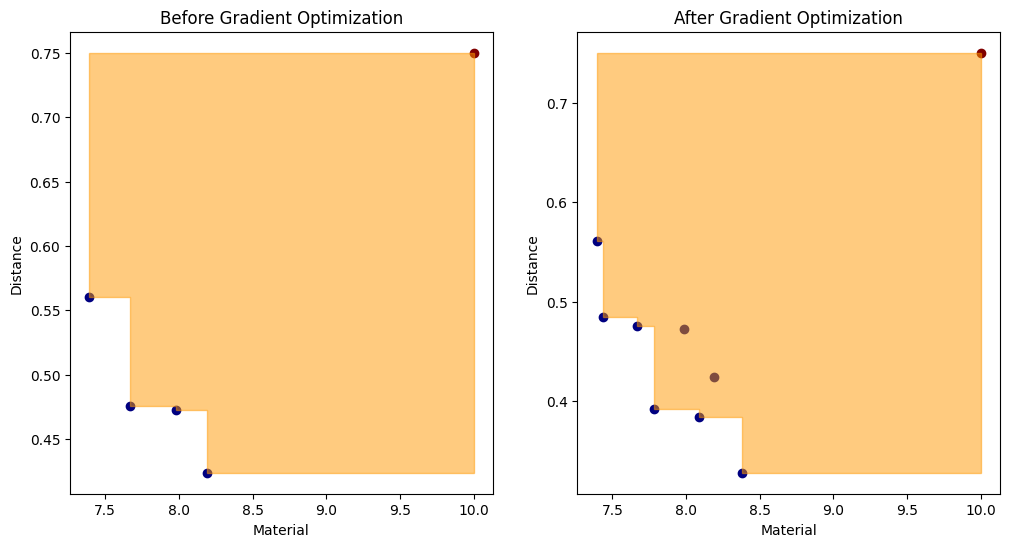

In [ ]:
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Before Gradient Optimization')
ga_visualizer.plot_HV(F_before, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

plt.subplot(1, 2, 2)
plt.title('After Gradient Optimization')
ga_visualizer.plot_HV(F, ref, objective_labels=['Distance', 'Material'], ax=plt.gca())

A small improvement. But this is just to give you an idea of what you can do when mixing optimization methods.

Now you should have a good idea of how to use the tools we have provided to you. Think about how you can improve each aspect of the optimization to achieve a higher score in you final submission. You are allowed also submit your teams best solutions to the leaderboard which we will announce soon and see how well you are doing compared other teams.

A few hints and ideas:
- Why not do some preprocessing to random mechanisms before running GA?
- Can you use the gradients of both functions in gradient based optimization? 
- Can you cycle through multiple optimization runs?
- Can you mix different kinds of GA? We showed how GA can be used for a single mechanism skeleton and how it can be used to also create the mechanisms?
- Can you modify the GA mutations and cross-over?
- Is there a more efficient representation of mechanisms we can use?
- Are there smarter gradient-based optimization methods?

# Appendix and Details

## Curve Distance Calculation

The target curves are provided to you as a sequence of points. The curves your mechanisms generate are then re-oriented compared to the target curves as we showed above. We measure the closeness of two point curves by computing the distance between the two curves with optimal alignment. This distance can be mathematically represented as:

$$
d_{OD}=\frac{2 \pi}{N}\min_{o_1 \in O_1, \alpha \in [0,2\pi)} \sum_{i=1}^N\left\|N(\mathbf{X}^{\text{coupler}}_{o_1(i)})\mathbf{R}(\alpha)-N(\mathbf{X}^{\text{target}})\right\|^2,
$$

$$\operatorname{N}(\mathbf{X})=\frac{\mathbf{X}- \overline{\mathbf{X}}}{\sqrt{\frac{\sum_{i=1}^N\|\mathbf{X}_i-\overline{\mathbf{X}}\|_2^2}{N}}}$$

Where $\mathbf{X}^{\text{coupler}}$ is the curve traced by the mechanism and $\mathbf{X}^{\text{target}}$ is the target curve and  $O_1$ is the set of all possible clockwise and counterclockwise orderings of a curve with $N$ ordered points and $\mathbf{R}(\alpha)$ is a $2\times2$ rotation matrix for angle $\alpha$, while $o_1(i)$ refers to the index of the $i$-th point in the set $o_1$. In practice, in our problem we may ignore the denominator in $N$ since we do not want to optimally rescale curves. The code we provide solves this optimization problem and retuns the distance value so you don't have to worry about this.

The other objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all links in the mechanism. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

### A Note On Scale Normalization

The functions that we saw in the starter notebool on curves, namely `compare_curves` and `visualize_comparison`, and `visualize_alignment` have a scaling option. An important input to the `CurveEngine` class is `normalize_scale`, which if set to `True` will rescale curves when comparing. In our problem we want this to be `False` since we care about the scale and material used in the problem. (We stress this distinction because the first component of the optimization demo had this rescaling turned on!)

In [ ]:
curve_processor = CurveEngine(
    normalize_scale=True, # whether to normalize the curve's scale (This would mean we do not care about the size of the curve but we do!)
    device='cpu' # device to run the processing on
)

curve_processor_unscaled = CurveEngine(
    normalize_scale=False, # do not normalize the scale of the curve (This would mean we care about the size of the curve too!)
    device='cpu'
)

Let's go back to the simple fourbar we had and see what this means:

<Axes: >

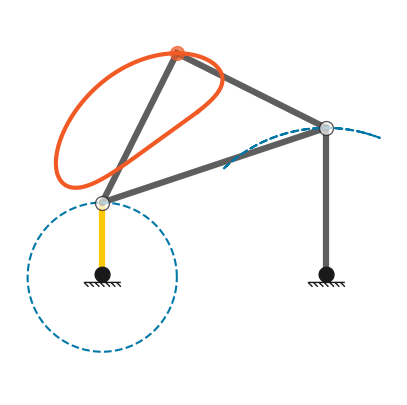

In [ ]:
visualizer = MechanismVisualizer()

# Define the variables for the mechanism
x0 = np.array([[0.3,0.2],
               [0.6,0.2],
               [0.3,0.3],
               [0.6,0.4],
               [0.4,0.5]])

# Define the connectivity of the mechanism
edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [3,4]])

# Define the fixed nodes
fixed_joints = np.array([0,1])

# actuator
motor = np.array([0,2])

plt.figure(figsize=(5,5))
visualizer(x0, edges, fixed_joints, motor, ax=plt.gca())

In [ ]:
solver = MechanismSolver(
    device = 'cpu' # device to run the simulation on (cpu or gpu)
)

solution = solver(x0, edges, fixed_joints, motor)
traced_curve = solution[4]

In [ ]:
# lets compare to the first target curve
distance = curve_processor.compare_curves(traced_curve, target_curves[0])
unscaled_distance = curve_processor_unscaled.compare_curves(traced_curve, target_curves[0])

print(f"The scale normalized distance to target curve 1 is: {distance:.4f}")
print(f"The unnormalized distance to target curve 1 is: {unscaled_distance:.4f}") # This will be higher since do not normalize scale

The scale normalized distance to target curve 1 is: 1.4590
The unnormalized distance to target curve 1 is: 3.3600


Now let's visualize the alignment process with and without scale to understand what is going on:

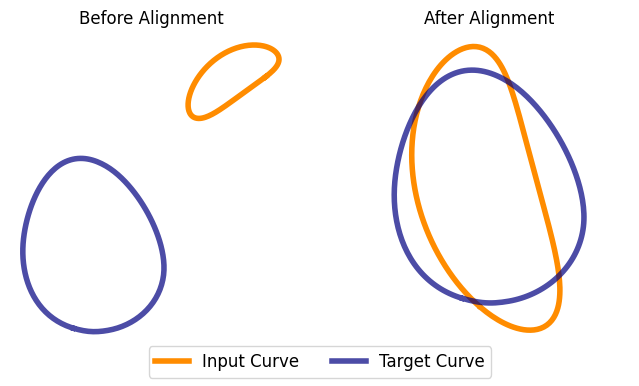

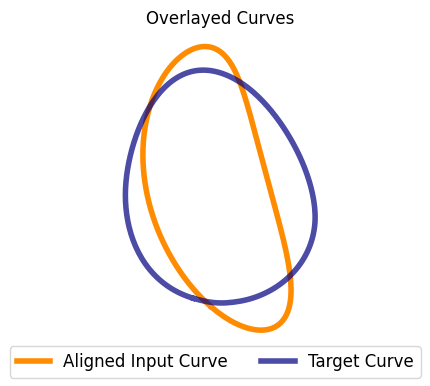

In [ ]:
curve_processor.visualize_alignment(traced_curve, target_curves[0])
curve_processor.visualize_comparison(traced_curve, target_curves[0])

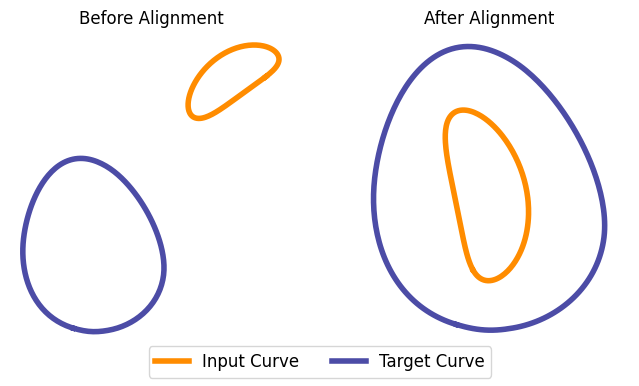

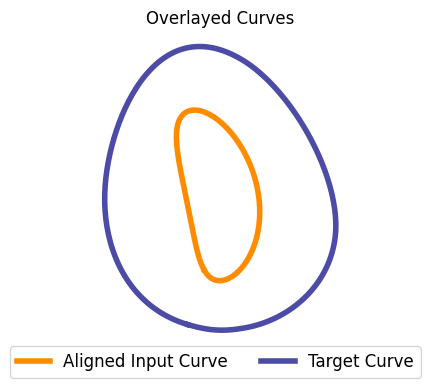

In [ ]:
curve_processor_unscaled.visualize_alignment(traced_curve, target_curves[0])
curve_processor_unscaled.visualize_comparison(traced_curve, target_curves[0])